# Estimating Eigenfunctions of the Trasnfer Operator

_Author_: [Pietro Novelli](https://pietronvll.github.io/)

In [136]:
from kooplearn.datasets import make_prinz_potential
import matplotlib.pyplot as plt
from kooplearn.kernel import KernelRidge
from tqdm import tqdm
import numpy as np
from scipy.integrate import romb
from math import sqrt

In [164]:
gamma = 1.0
sigma = 2.0
data = make_prinz_potential(X0 = 0, n_steps=int(1e6), gamma=gamma, sigma=sigma)

In [192]:
def prinz_potential(x):
    return 4*(x**8+ 0.8*np.exp(-80*(x**2)) +  0.2*np.exp(-80*((x - 0.5)**2)) + 0.5*np.exp(-40*((x + 0.5)**2)))

def compute_boltzmann_density(gamma, sigma, xv):
    kT = sigma*sigma/(2*gamma)
    pdf = np.exp(-prinz_potential(xv)/kT)
    total_mass = romb(pdf, dx=xv[1] - xv[0])
    return pdf/total_mass

In [193]:
xv = np.linspace(-3, 3, 2048 + 1)
density = compute_boltzmann_density(gamma, sigma, xv)

(-1.0, 1.0)

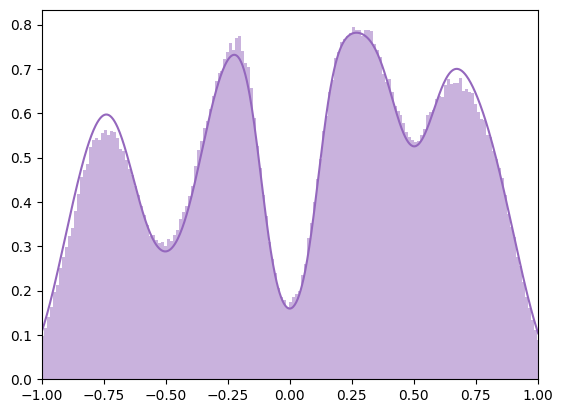

In [199]:
plt.hist(data, bins=200, density=True, alpha=0.5, color="tab:purple");
plt.plot(xv, density, color='tab:purple')
plt.xlim(-1, 1)

<Axes: xlabel='time'>

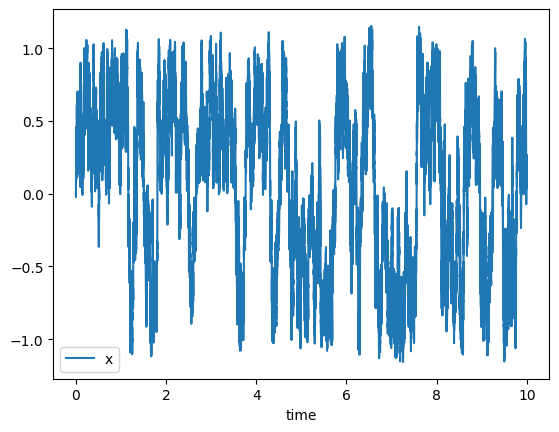

In [109]:
data.reset_index().plot(x='time', y='x')

In [299]:
def estimate_eigfuns(reduced_rank: bool, n_repetitions: int = 1):
    xv = np.linspace(-2, 2, 2048 + 1)
    density = compute_boltzmann_density(gamma, sigma, xv)
    values, functions = map(
        np.array,
        zip(
            *(
                fit_and_estimate(reduced_rank, xv, density)
                for _ in tqdm(range(n_repetitions))
            )
        ),
    )
    for i in range(1, n_repetitions):
        for j in range(functions.shape[-1]):
            functions[i, :, j] = standardize_sign(functions[i, : ,j], functions[0, : ,j])
    return values, functions, xv


def fit_and_estimate(reduced_rank, xv, density):
    subsample = 100
    gamma = 1.0
    sigma = 2.0
    data = make_prinz_potential(X0=0, n_steps=int(5e5), gamma=gamma, sigma=sigma).iloc[
        ::subsample
    ]
    model = KernelRidge(
        n_components=5, reduced_rank=reduced_rank, gamma=12.5, kernel="rbf", alpha=1e-6
    )
    model.fit(data)
    values, functions = model.eig(eval_right_on=xv[:, None])
    # Descending order
    values = np.flip(values)
    functions = np.flip(functions, axis=1)
    functions = normalize_eigenfunctions(functions, xv, density)
    return values, functions


def normalize_eigenfunctions(functions, xv, density):
    dx = xv[1] - xv[0]
    abs2_eigfun = (np.abs(functions) ** 2).T
    if density is not None:
        abs2_eigfun *= density
    # Norms
    funcs_norm = np.sqrt(romb(abs2_eigfun, dx=dx, axis=1))
    functions *= funcs_norm**-1.0
    return functions

def standardize_sign(current, reference):
    norm_p = np.linalg.norm(current + reference)
    norm_m = np.linalg.norm(current - reference)
    if norm_p <= norm_m:
        return -1.0*current
    else:
        return current

In [300]:
n_repetitions = 10
results = {}
for method, reduced_rank in zip(["Principal Components (kDMD)", "Reduced Rank"], [False, True]):
    _, functions, xv = estimate_eigfuns(reduced_rank, n_repetitions=n_repetitions)
    results[method] = functions

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


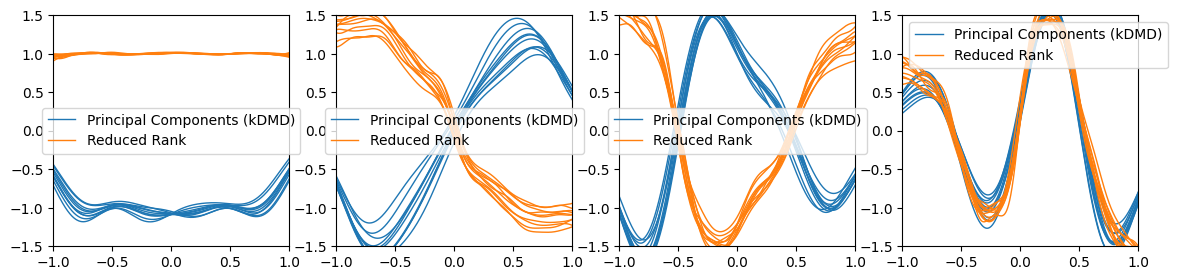

In [301]:
fig, axs = plt.subplots(ncols=4, figsize=(14, 3))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        color = 'tab:blue' if 'Principal' in method else 'tab:orange'
        for replica_fn in functions[:-1]:
            ax.plot(xv, replica_fn[:, fun_id], color=color, lw=1)
        ax.plot(xv, functions[-1, :, fun_id], color=color, lw=1, label=method)
    ax.legend()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1.5, 1.5)

In [ ]:
density